# RTML Lab 4: YOLO (v3 and v7)

NAME = "Todsavad Tangtortan"
ID = "123012"

# New Homework (Will release on 3 Feb 2023)

## Independent exercise: YOLOR
### Part I: Inference (due next week)

In the lab, we saw how the Darknet configuration file for YOLOv3 could be read in Python and mapped
to PyTorch modules.

For your independent work do the same thing for YOLOv4. Download the `yolov4.cfg` file
from the [YOLOv4 GitHub repository](https://github.com/AlexeyAB/darknet) and modify your
`MyDarknet` class and utility code (`darknet.py`, `util.py`) as
necessary to map the structures to PyTorch.

The changes you'll have to make:

1. Implement the mish activation function
2. Add an option for a maxpool layer in the `create_modules` function and in your model's `forward()` method.
3. Enable a `[route]` module to concatenate more than two previous layers
4. Load the pre-trained weights [provided by the authors](https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights)
4. Scale inputs to 608$\times$608 and make sure you're passing input channels in RGB order, not OpenCV's BGR order.

## Modify `darknet.py`
- Implement the mish activation function.

        class Mish(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                return x * torch.tanh(F.softplus(x))
                
        if activation == "mish":
            activn = Mish()
            module.add_module("mish_{0}".format(index), activn)
            
- Add an option for a maxpool layer in the `create_modules` function.

        
        elif x["type"] == "maxpool":
            stride = int(x["stride"])
            size = int(x["size"])
            assert size % 2
            maxpool = nn.MaxPool2d(kernel_size=size, stride=stride, padding=size // 2)
            module.add_module("maxpool_{0}".format(index), maxpool)

- Add condition in your model's `forward()` method.

        if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":
            x = self.module_list[i](x)

- Enable a `[route]` module to concatenate more than two previous layers


        elif module_type == "route":
                
            # concat layers
            layers = module["layers"]
            layers = [int(a) for a in layers]
            
            if (layers[0]) > 0:
                layers[0] = layers[0] - i

            if len(layers) == 1:    # 1 item in layer                 
                x = outputs[i + (layers[0])]

            else:   # more than 1 item in layer 
                if len(layers) == 4:       # 4 items in layer                                      
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i

                    if (layers[2]) > 0:
                        layers[2] = layers[2] - i

                    if (layers[3]) > 0:
                        layers[3] = layers[3] - i

                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    map3 = outputs[i + layers[2]]
                    map4 = outputs[i + layers[3]]
                    x = torch.cat((map1, map2, map3, map4), 1)

                else:           # 2 items in layer                
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
    
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    x = torch.cat((map1, map2), 1)

- Load the pre-trained weights [provided by the authors](https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights)

        model = Darknet("cfg/yolov4.cfg")
        model.load_weights("yolov4.weights")

- Scale inputs to 608$\times$608 and make sure you're passing input channels in RGB order, not OpenCV's BGR order.

## Modify `util.py`

        def prep_image(img, inp_dim):
            """
            Prepare image for inputting to the neural network. 
            
            Returns a Variable 
            """
            # pylint: disable=no-member
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = letterbox_image(img, (inp_dim, inp_dim))
            img = img[:,:,::-1].transpose((2,0,1)).copy()
            img =  torch.from_numpy(img).float().div(255.0).unsqueeze(0)

In [1]:
from darknet import *
import torch
import cv2
from util import *

def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

model = Darknet("cfg/yolov4.cfg")
model.module_list[114].conv_114 = nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
input = get_test_input()
print(input.shape)
prediction = model(input, False)
# print(prediction)
print(prediction.shape)

model.load_weights("yolov4.weights")
input = get_test_input()
prediction = model(input, False)
write_results(prediction.detach(), 0.5, 80, nms_conf = 0.4)
# print(prediction)
print(prediction.shape)
# num_classes = 80
# classes = load_classes("../data/coco.names")

# print(classes)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 3, 608, 608])
torch.Size([1, 22743, 85])
torch.Size([1, 22743, 85])


In [15]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
import argparse
import os 
import os.path as osp
from darknet import Darknet
import pickle as pkl
import pandas as pd
import random

images = "cocoimages"
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
CUDA = torch.cuda.is_available()

num_classes = 80
classes = load_classes("data/coco.names")

#Set up the neural network
print("Loading network.....")
model = Darknet("cfg/yolov4.cfg")
# Edit Convo Layer 114
# Here we need to edit this layer because previously the input channel to this was set as 1024 
# but actually this layer needs to accept the input from the concatenation of four 512-channel layers 
# so I need to modify this layer to have input channel of 2048
model.module_list[114].conv_114 = nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
model.load_weights("yolov4.weights")
print("Network successfully loaded")

model.net_info["height"] = 608
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

#If there's a GPU availible, put the model on GPU

if CUDA:
    model.cuda()

# Set the model in evaluation mode

model.eval()

read_dir = time.time()

# Detection phase

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()

if not os.path.exists("des"):
    os.makedirs("des")

load_batch = time.time()
loaded_ims = [cv2.imread(x) for x in imlist]

im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
im_dim_list = [(x.shape[1], x.shape[0]) for x in loaded_ims]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)
# print(im_dim_list)

leftover = 0
if (len(im_dim_list) % batch_size):
    leftover = 1

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]  

write = 0

if CUDA:
    im_dim_list = im_dim_list.cuda()
    
start_det_loop = time.time()
for i, batch in enumerate(im_batches):
    # Load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(prediction, confidence, num_classes, nms_conf = nms_thesh)

    end = time.time()

    if type(prediction) == int:

        for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
            im_id = i*batch_size + im_num
            print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
            print("{0:20s} {1:s}".format("Objects Detected:", ""))
            print("----------------------------------------------------------")
        continue

    prediction[:,0] += i*batch_size    #transform the atribute from index in batch to index in imlist 

    if not write:                      #If we have't initialised output
        output = prediction  
        write = 1
    else:
        output = torch.cat((output,prediction))

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")

    if CUDA:
        torch.cuda.synchronize()       
try:
    output
except NameError:
    print ("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(model.net_info["height"]/im_dim_list,1)[0].view(-1,1)

output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2

output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    
output_recast = time.time()
class_load = time.time()
colors = [[255, 0, 0], [255, 0, 0], [255, 255, 0], [0, 255, 0], [0, 255, 255], [0, 0, 255], [255, 0, 255]]

draw = time.time()

def write(x, results):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
    color = random.choice(colors)
    label = "{0}".format(classes[cls])
    cv2.rectangle(img,(int(c1[0]), int(c1[1])),(int(c2[0]), int(c2[1])),color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img,(int(c1[0]), int(c1[1])) ,(int(c2[0]), int(c2[1])) ,color, -1)
    cv2.putText(img, label, (int(c1[0]), int(c1[1]) + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


list(map(lambda x: write(x, loaded_ims), output))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("des",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, loaded_ims))
end = time.time()

print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")

torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
dog-cycle-car.png    predicted in  0.055 seconds
Objects Detected:    bicycle truck dog
----------------------------------------------------------
1.jpg                predicted in  0.067 seconds
Objects Detected:    wine glass wine glass wine glass wine glass wine glass wine glass cup knife knife cake diningtable
----------------------------------------------------------
2.jpg                predicted in  0.055 seconds
Objects Detected:    wine glass wine glass wine glass knife chair vase
----------------------------------------------------------
3.jpg                predicted in  0.049 seconds
Objects Detected:    person person banana
----------------------------------------------------------
4.jpg                predicted in  0.054 seconds
Objects Detected:    person person person person person person person train
----------------------------------------------------------
5.jpg                predicted in  0.056 seconds
Objects Detect

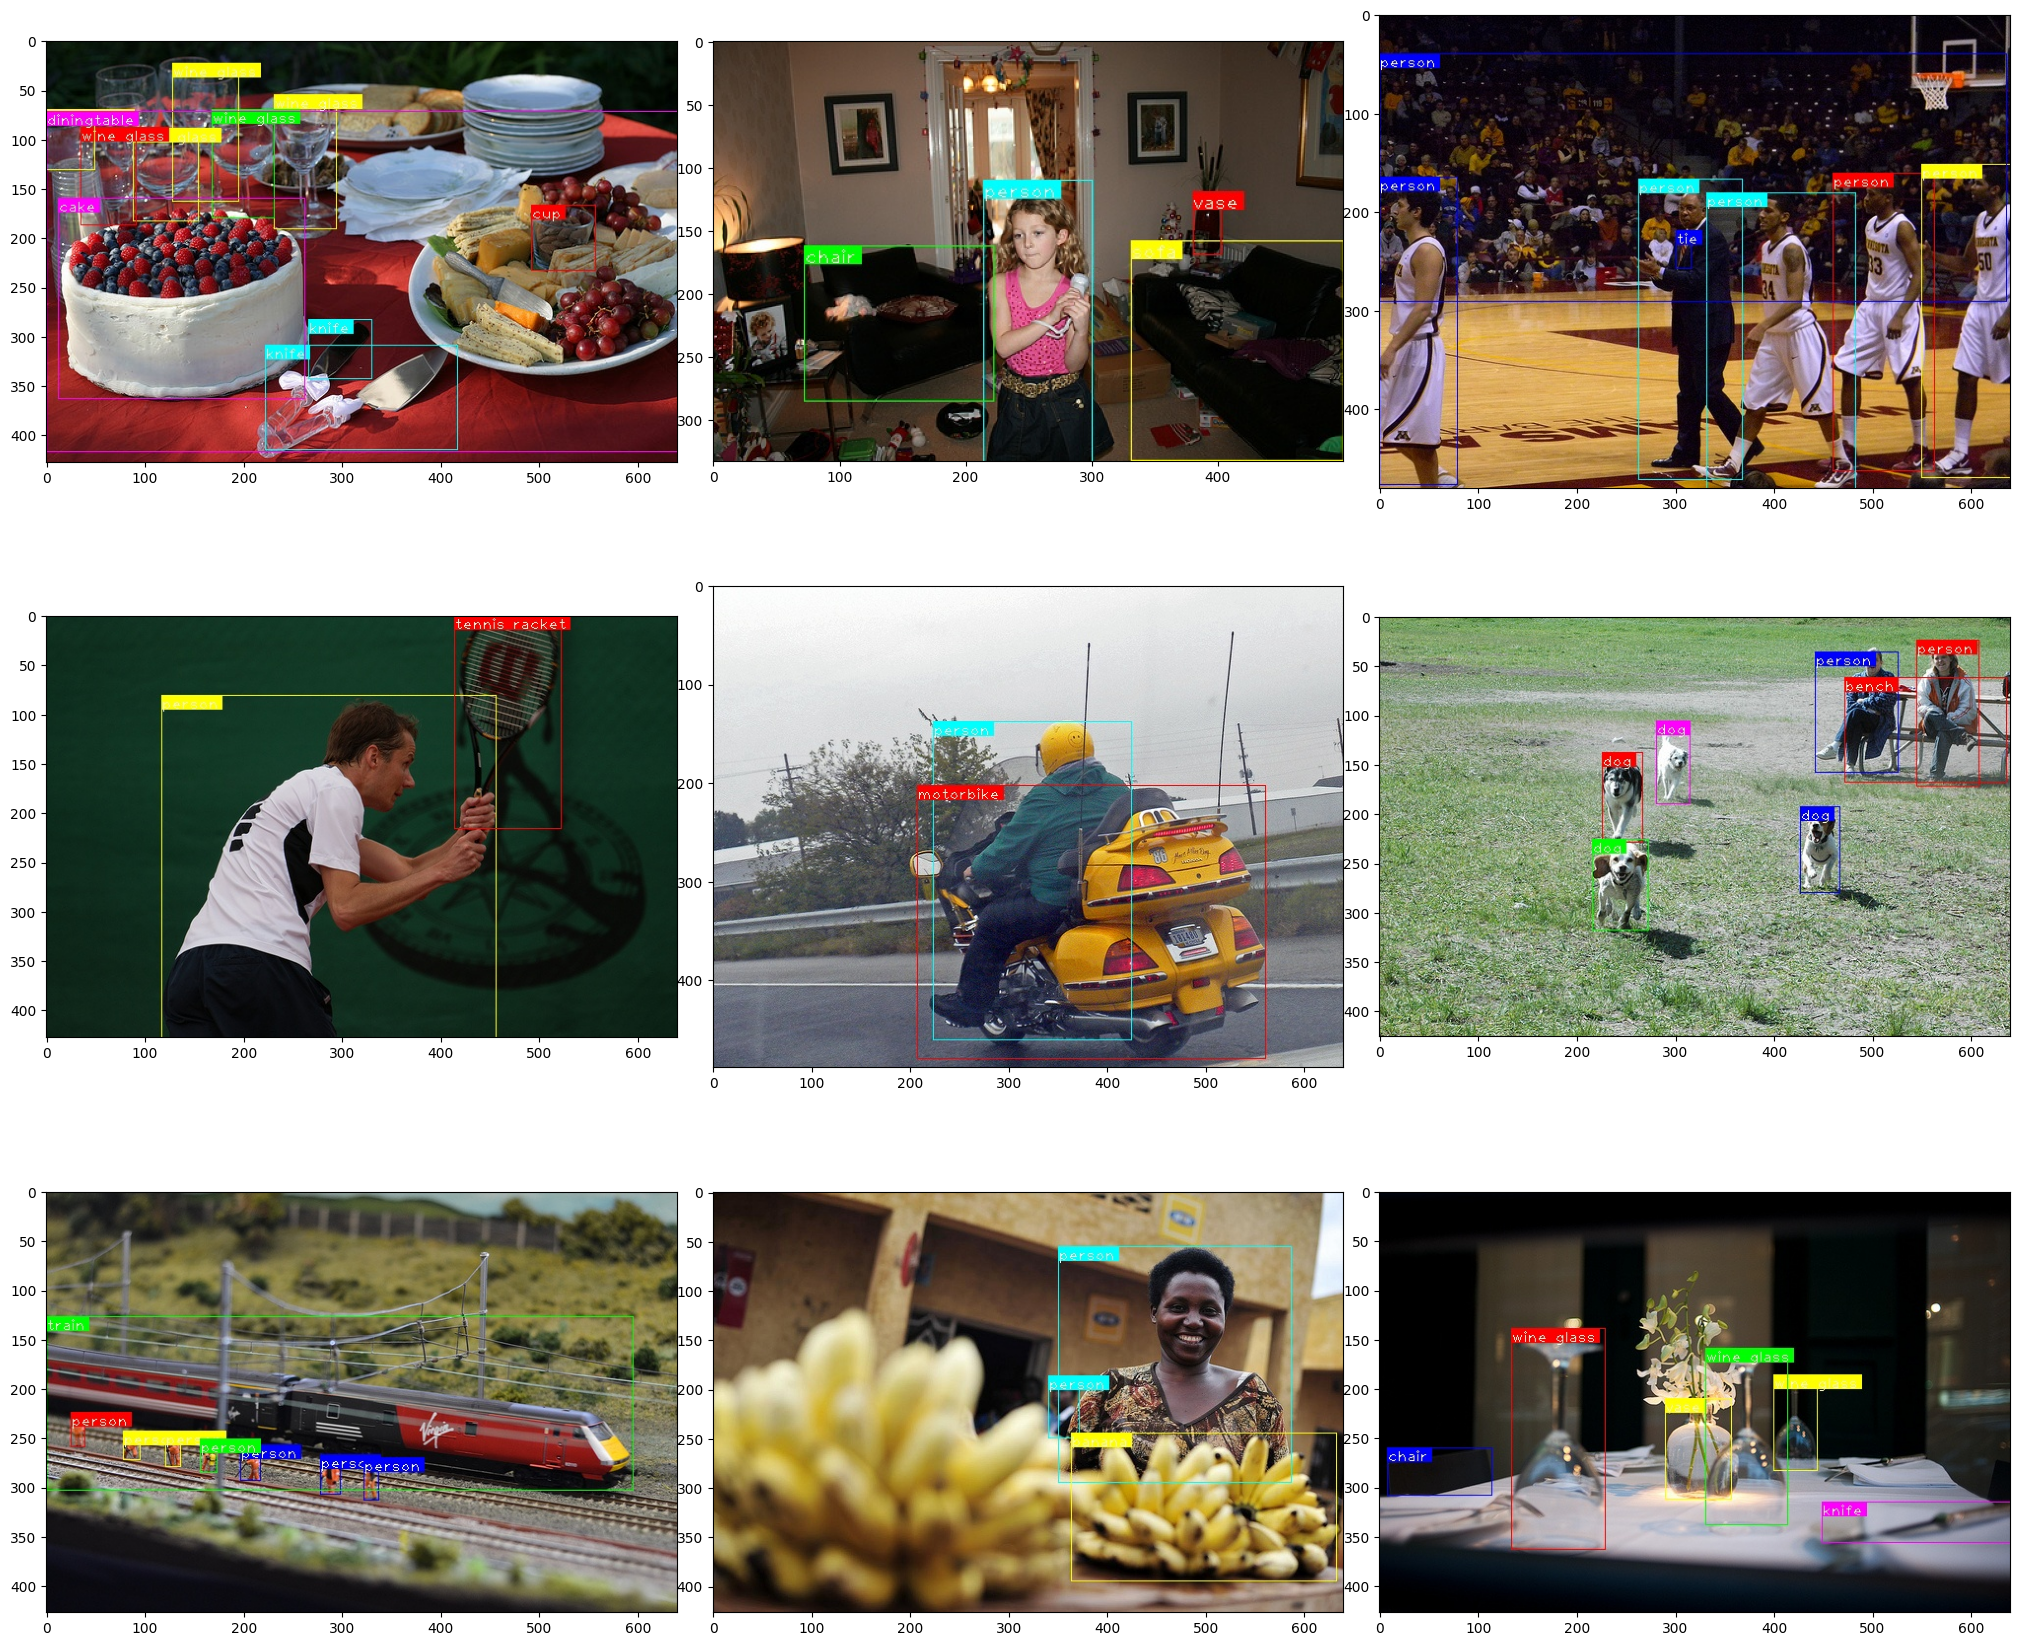

In [16]:
import cv2
import matplotlib.pyplot as plt
import glob

detected = []
for img in glob.glob("des/*.jpg"):
    cv_img = cv2.imread(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    detected.append(cv_img)

rows = 3
cols = 3
axes = []
fig = plt.figure(figsize=(20,20))
for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1) )
    plt.imshow(detected[-a])
    fig.tight_layout(pad=0)
    fig.show()

### Part II: Training (due in two weeks)

Train the YOLOv4 model on the COCO dataset (or another dataset if you have one available).
Here the purpose is not to get the best possible model (that would require implementing all
of the "bag of freebies" training tricks described in the paper), but just some of them, to
get a feel for their importance.

1. Get a set of ImageNet pretrained weights for CSPDarknet53 [from the Darknet GitHub repository](https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/csdarknet53-omega_final.weights)
2. Add a method to load the pretrained weights into the backbone portion of your PyTorch YOLOv4 model.
3. Implement a basic `train_yolo` function similar to the `train_model` function you developed in previous
   labs for classifiers that preprocesses the input with basic augmentation transformations, converts the
   anchor-relative outputs to bounding box coordinates, computes MSE loss for the bounding box coordinates,
   backpropagates the loss, and takes a step for the optimizer. Use the recommended IoU thresholds to determine
   which predicted bounding boxes to include in the loss. You will find many examples of how to do this
   online.
4. Train your model on COCO. Training on the full dataset to completion would take several days, so you can stop early after verifying
   the model is learning in the first few epochs.
5. Compute mAP for your model on the COCO validation set.
6. Implement the CIoU loss function and observe its effect on mAP.
7. (Optional) Train on COCO to completion and see how close you can get to the mAP reported in the paper.

There is some useful information on working with the COCO dataset as a
Torchvision Dataset in [this blog](https://medium.com/howtoai/pytorch-torchvision-coco-dataset-b7f5e8cad82).
For your work on this lab, the instructor will place the entire COCO training and validation datasets on a shared network drive for you to access
so that we don't use resources for multiple copies of the dataset. Once you have access to the dataset you can use the dataset easily:

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((608,608)),
    transforms.CenterCrop(608),
    transforms.ToTensor()])

path2data =
path2json =

coco_train = dset.CocoDetection(root = path2data, annFile = path2json, transform=transform)

print('Number of samples: ', len(coco_train))

In [ ]:
import numpy as np
import torch 
def collate(batch):
    images = []
    bboxes = []
    for img, box in batch:
        images.append([img])
        bboxes.append([box])
    images = np.concatenate(images, axis=0)
    images = images.transpose(0, 3, 1, 2)
    images = torch.from_numpy(images).div(255.0)
    bboxes = np.concatenate(bboxes, axis=0)
    bboxes = torch.from_numpy(bboxes)
    return images, bboxes


In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(coco_train, batch_size=50 // 5, shuffle=True,
                              num_workers=1, pin_memory=True, drop_last=True, collate_fn=collate)